In [44]:
import pandas as pd 
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer


In [45]:
df = pd.read_csv(r'../../resources/dataset_sentimientos_robusto.csv')
df.head()

,id,texto,sentimiento,categoria,fecha,dia_semana,hora_aproximada,es_fin_de_semana,calificacion,canal,...,num_palabras,tiene_mayusculas_excesivas,num_signos_exclamacion,tiempo_respuesta_horas,fue_respondido,resolucion,prioridad,requiere_atencion_inmediata,confianza_modelo,requiere_revision_humana
0,1,Es aceptable,Neutro,Soporte Técnico,2024-12-09,Monday,Noche,False,3,Teléfono,...,2,False,0,36.0,True,NaN,Media,False,0.76,True
1,2,Es adecuado. Servicio regular,Neutro,Delivery,2025-08-03,Sunday,Tarde,True,3,Email,...,4,False,0,55.0,True,Resuelto,Baja,False,0.64,True
2,3,El servicio fue malísimo!,Negativo,Delivery,2024-02-04,Sunday,Noche,True,1,App Móvil,...,4,False,1,NaN,False,NaN,Media,False,0.81,False
3,4,Entrega rápida y producto impecable. Servicio ...,Positivo,Aplicación Móvil,2025-11-15,Saturday,Mañana,True,5,Email,...,9,False,1,NaN,False,NaN,Baja,False,0.85,False
4,5,No lo recomiendo para nada,Negativo,Hotel,2024-09-26,Thursday,Noche,False,1,Chat,...,5,False,0,NaN,False,NaN,Media,False,0.94,False


In [46]:
df = df[['texto', 'sentimiento']]
df.head()

,texto,sentimiento
0,Es aceptable,Neutro
1,Es adecuado. Servicio regular,Neutro
2,El servicio fue malísimo!,Negativo
3,Entrega rápida y producto impecable. Servicio ...,Positivo
4,No lo recomiendo para nada,Negativo


In [47]:
distribucion_sentimentos = round(df['sentimiento'].value_counts(normalize = True)*100,2)
print(distribucion_sentimentos)

sentimiento
Positivo    45.0
Negativo    30.0
Neutro      25.0
Name: proportion, dtype: float64


In [48]:
corpus_entrenamiento, corpus_prueba, y_entrenamiento, y_prueba = train_test_split(
    df['texto'],
    df['sentimiento'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['sentimiento'])

In [49]:
def print_distribution(name, series):
    series = pd.Series(series)
    dist = series.value_counts(normalize=True)
    print(f"{name} Distribution:\n{dist}\n")

# Maintains the original Odyssey/Iliad ratio
print_distribution("Distribución Entrenamiento", y_entrenamiento)
print_distribution("Distribución Prueba", y_prueba)

Distribución Entrenamiento Distribution:
sentimiento
Positivo    0.45
Negativo    0.30
Neutro      0.25
Name: proportion, dtype: float64

Distribución Prueba Distribution:
sentimiento
Positivo    0.45
Negativo    0.30
Neutro      0.25
Name: proportion, dtype: float64



In [50]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Eliminar stopwords y lematizar
stopword_list = set(stopwords.words('spanish'))

def procesar_texto_español(texto):
    """
    Función para limpiar y preprocesar texto en español.
    """
    # Manejo de valores nulos
    if not isinstance(texto, str):
        return ""
    
    # Eliminar HTML
    texto = BeautifulSoup(texto, "html.parser").get_text()
    
    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar emojis
    texto = re.sub(r"[^\w\sáéíóúñü]",
        "",
        texto)
    
    # Tokenizar
    tokens = word_tokenize(texto, language='spanish')
    
    # Eliminar stopwords y lematizar
    tokens_limpios = [token for token in tokens if token not in stopword_list and len(token) > 2]
    return ' '.join(tokens_limpios) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
corpus_entrenamiento_normalizado = [procesar_texto_español(text) for text in corpus_entrenamiento]
corpus_prueba_normalizado = [procesar_texto_español(text) for text in corpus_prueba]

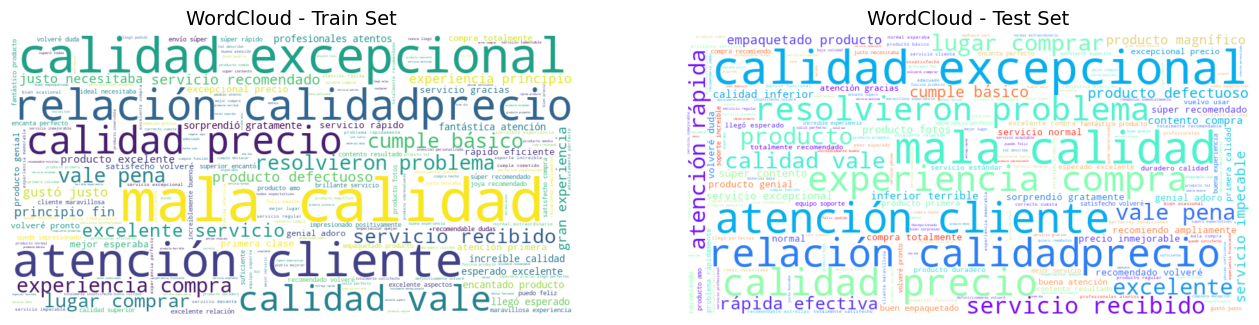

In [52]:
texto_entrenamiento = " ".join(corpus_entrenamiento_normalizado)
texto_prueba = " ".join(corpus_prueba_normalizado)

wc_train = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(texto_entrenamiento)
wc_test = WordCloud(width=800, height=400, background_color="white", colormap="rainbow").generate(texto_prueba)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(wc_train, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Train Set", fontsize=14)

plt.subplot(1,2,2)
plt.imshow(wc_test, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Test Set", fontsize=14)

plt.show()

In [53]:
vectorizer = TfidfVectorizer(
    norm= 'l2',
    smooth_idf= True,
    use_idf= True,
    ngram_range= (1,2), 
    max_df= 0.90,
    min_df= 2)

tfidf_matrix_entrenamiento = vectorizer.fit_transform(corpus_entrenamiento_normalizado)
tfidf_matrix_prueba = vectorizer.transform(corpus_prueba_normalizado)


In [54]:
np.unique(y_prueba)

array(['Negativo', 'Neutro', 'Positivo'], dtype=object)

In [55]:
def evaluacion_modelos(y_real, y_pred):
    
    labels = ['Negativo', 'Neutro', 'Positivo']

    print(f'Accuracy: {round(accuracy_score(y_real, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_real, y_pred, average= "weighted"),2)}')
    print(f'F1-Score: {round(f1_score(y_real, y_pred, average= "weighted"),2)}')
    print(f'Recall: {round(recall_score(y_real, y_pred, average= "weighted"),2)}')
    
    matriz_confusion_modelo = confusion_matrix(y_real, y_pred)
    visualizacion_matriz_confusion = ConfusionMatrixDisplay(matriz_confusion_modelo, display_labels= labels)
    visualizacion_matriz_confusion.plot();


In [56]:
tfidf_matrix_entrenamiento.shape, tfidf_matrix_prueba.shape

((12000, 1438), (3000, 1438))

In [57]:
modelo_lr = LogisticRegression(
    max_iter= 1000,
    random_state= 42,
    class_weight= 'balanced')

modelo_lr.fit(tfidf_matrix_entrenamiento, y_entrenamiento)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [58]:
y_pred_lr = modelo_lr.predict(tfidf_matrix_prueba)
y_proba_lr = modelo_lr.predict_proba(tfidf_matrix_prueba)

Accuracy: 1.0
Precision: 1.0
F1-Score: 1.0
Recall: 1.0


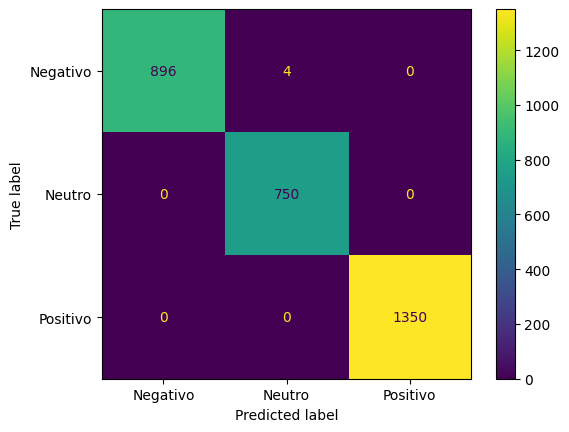

In [59]:
evaluacion_modelos(y_prueba,y_pred_lr)